In [1]:
#Pre-Processing of an image --

import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(image_path):
    # Load the image
    global image
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Display the original and grayscale images for verification
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Grayscale Image")
    plt.imshow(gray_image, cmap='gray')
    plt.show()
    
    return gray_image


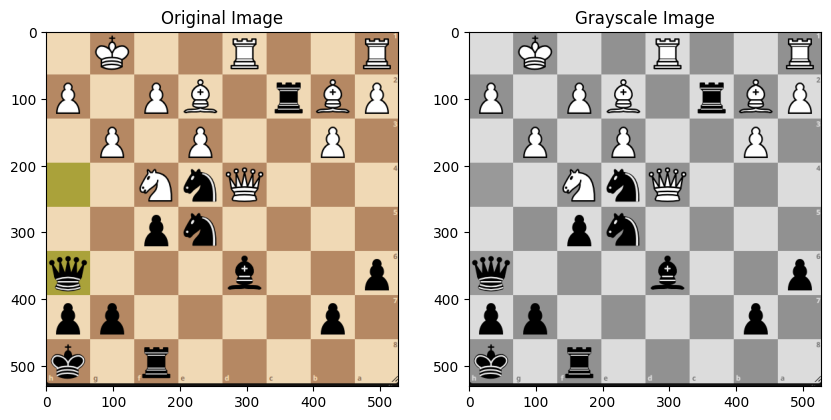

In [2]:
gray_image =load_and_preprocess_image(r'C:\Users\ASUS\FENgine\data\Position.PNG')

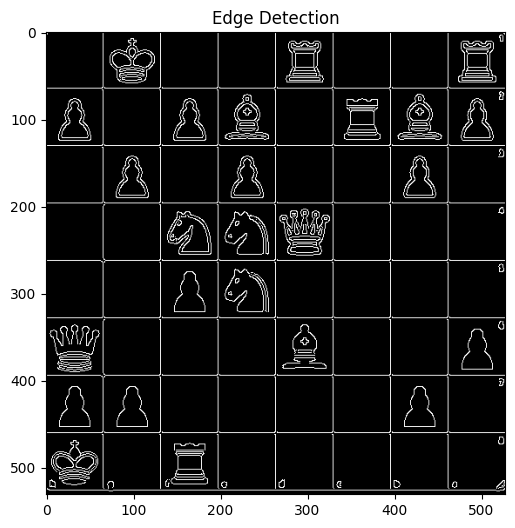

In [3]:
def detect_edges(image):
    # Apply Gaussian Blur to reduce noise and improve edge detection
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
    
    # Display the edge-detected image
    plt.figure(figsize=(6, 6))
    plt.title("Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.show()
    
    return edges

# Example usage
edges = detect_edges(gray_image)

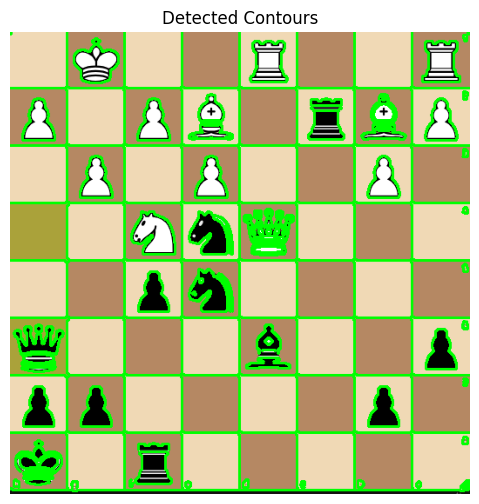

In [24]:
def find_chessboard_contours(edges, original_image):
    # Step 1: Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 2: Filter contours based on area to find the chessboard and pieces
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 0.1:  # Example area threshold, adjust as needed
            valid_contours.append(contour)

    # Step 3: Draw contours on the original image for visualization
    image_with_contours = original_image.copy()
    cv2.drawContours(image_with_contours, valid_contours, -1, (0, 255, 0), 2)  # Draw contours in green

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.title("Detected Contours")
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()
    
    return valid_contours

# Example usage
valid_contours = find_chessboard_contours(edges, image)


In [25]:
def get_contour_centers(valid_contours):
    centers = []
    for contour in valid_contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:  # Bölme hatasını önlemek için
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))
    return centers

centers = get_contour_centers(valid_contours)


In [26]:
def extract_pieces(original_image, valid_contours):
    pieces = []
    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        piece_image = original_image[y:y+h, x:x+w]
        pieces.append(piece_image)
    return pieces

pieces = extract_pieces(image, valid_contours)


In [29]:
def classify_pieces(model, pieces):
    predictions = []
    for piece in pieces:
        piece_resized = cv2.resize(piece, (32, 32))  # Modelin girdi boyutu
        piece_array = np.expand_dims(piece_resized, axis=0)  # Model girişi için boyutlandır
        prediction = model.predict(piece_array)
        predictions.append(np.argmax(prediction))  # Tahmin edilen sınıf
    return predictions

# Örnek kullanım
#predictions = classify_pieces(your_model, pieces)


NameError: name 'your_model' is not defined

In [28]:
def generate_fen(positions):
    board = [["." for _ in range(8)] for _ in range(8)]  # 8x8 satranç tahtası
    for position in positions:
        x, y, piece_type = position  # x, y, taş tipi
        board[y][x] = piece_type  # Taşın konumunu yerleştir

    # FEN formatını oluştur
    fen = ""
    for row in board:
        empty_count = 0
        for square in row:
            if square == ".":
                empty_count += 1
            else:
                if empty_count > 0:
                    fen += str(empty_count)
                    empty_count = 0
                fen += square
        if empty_count > 0:
            fen += str(empty_count)
        fen += "/"  # Sırayı ayır

    return fen[:-1]  # Sonunda fazladan / var
